# Identifying Agriculture Disease in Tomatoes
---

In [0]:
from fastai import *
from fastai.vision import *
import numpy as np
from fastai.widgets import *
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [0]:
path = Path('/content/gdrive/My Drive/ML/data')

Let’s start by reading in the labels.

In [0]:
df_labels = pd.read_csv(path/'new_tomato_labels.csv')

In [0]:
print(df_labels.shape)
df_labels.head()

(11476, 2)


,disease_class,image_id
0,58,62ae85b3-ed7b-476b-8e83-0c40bcac46ac___YLCV_GC...
1,58,ccc340cd185349e59577a5afd7441e8f.jpg
2,58,12c02f3247f994afada98ab239a47f04.jpg
3,58,dd15c99d7145235477a57191534d8b99.jpg
4,58,67be104d-cbf0-4ec8-9137-6d3cc1f2b9ed___YLCV_GC...


In [0]:
df_labels['disease_class'].value_counts()

59    2473
58    1414
41    1208
49    1109
43     966
55     807
56     542
47     442
54     421
51     336
50     325
42     319
57     271
48     264
60     261
46     251
52      43
53      22
44       1
45       1
Name: disease_class, dtype: int64

Here we can see we have 11,476 total images and a few of the classes are quite imbalanced.

Now let’s create a DataBunch. This is a fastai concept and essentially combines PyTorch Dataset and DataLoader classes.

In [0]:
np.random.seed(25)
src = (ImageItemList.from_csv(path, 'new_tomato_labels.csv', folder='new_tomato_images', cols='image_id')
       .random_split_by_pct(0.1)
       .label_from_df('disease_class'))

In [0]:
data = (src.transform(get_transforms(flip_vert=True), size=128)
        .databunch().normalize(imagenet_stats))

get_transforms applies our data augmentation.

I am starting with an image size of 128. Later on I will change the image sizes to 256 and take the model trained on the images of size 128 and train it again on the larger images. This is essentially a transfer learning trick that can be beneficial on some datasets.

In [0]:
data.train_ds

LabelList
y: CategoryList (10329 items)
[Category 58, Category 58, Category 58, Category 58, Category 58]...
Path: /content/gdrive/My Drive/ML/data
x: ImageItemList (10329 items)
[Image (3, 362, 256), Image (3, 509, 256), Image (3, 422, 256), Image (3, 581, 256), Image (3, 465, 256)]...
Path: /content/gdrive/My Drive/ML/data

We can see that out training set consists of 10,329 images.

In [38]:
data.valid_ds

LabelList
y: CategoryList (1147 items)
[Category 55, Category 41, Category 49, Category 58, Category 43]...
Path: /content/gdrive/My Drive/ML/data
x: ImageItemList (1147 items)
[Image (3, 329, 256), Image (3, 559, 256), Image (3, 364, 256), Image (3, 399, 256), Image (3, 256, 400)]...
Path: /content/gdrive/My Drive/ML/data

We can see that out validation set consists of 1,147 images.

Let’s see what a leaf looks like.

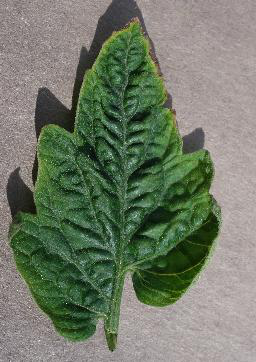

In [0]:
data.train_ds.x[0]

In [0]:
data.train_ds.y[0]

Category 58

This leaf suffers from Tomato YLCV Virus general: class 58

Let's also look at a batch of images.

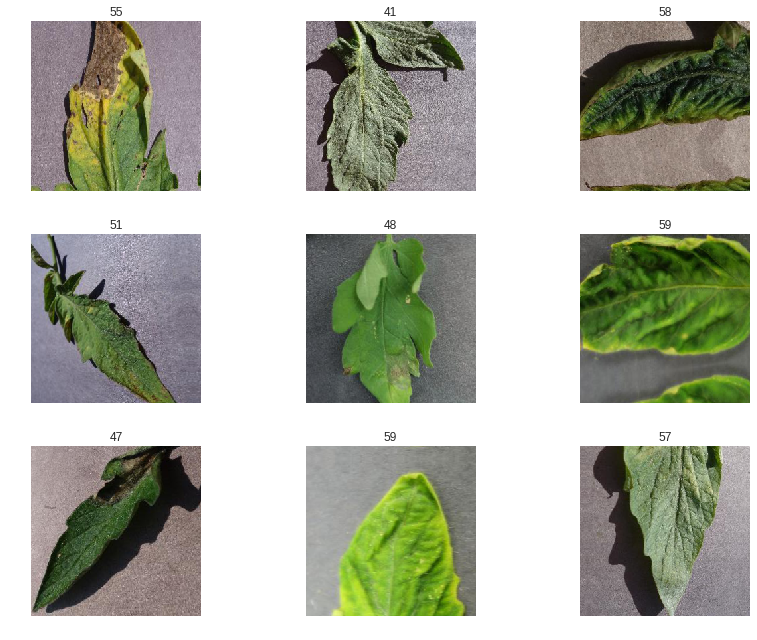

In [39]:
data.show_batch(rows=3, figsize=(12,9))

We can see examples of zoom, vertical flip, horizontal flips and perspective warping from our data augmentation process in some images.

It's time to create our model.

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In fastai, we create a “learn” object which represents our model. We can see the weights from resnet34 being downloaded.

Let's start with the learning rate finder.  This is a really useful technique for finding the optimal learning rate for a given architecture and dataset.  The premise of the LR finder is outlined in this paper: 
[Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


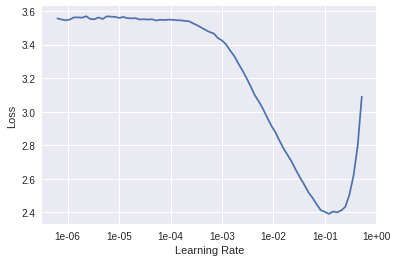

In [41]:
learn.lr_find()
learn.recorder.plot()

How do we derive a learning rate from this? Well, the technique suggested by Jermey Howard is to find the learning rate with the lowest loss and then go back roughly a factor of 10. Here 1e-1 has the lowest loss so we would drop back to 1e-2 and use this for our initial learning rate.

In [16]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,1.399443,0.816288,0.282476
2,0.873806,0.623570,0.231909
3,0.711821,0.547981,0.204010
4,0.629966,0.503674,0.184830
5,0.572280,0.498277,0.186574


Above we are training our model using fit_one_cycle. This is a really useful technique for training models. It essentially slowly increases our LR for the first half of epochs and then slowly decreases our LR for the last half of epochs. Momentum is applied in an inverse fashion. Starting out relatively high and slowly decreasing for the first half of epochs and then increases for the last half of epochs.

In [0]:
learn.save('stage-1-res34-tom')

Time to unfreeze the resnet50 layers for some fine tuning.

In [0]:
learn.unfreeze()

In [19]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


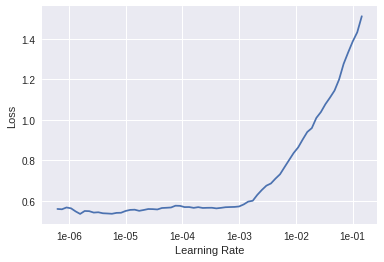

In [20]:
learn.recorder.plot()

Here we can see that the LR finder plot looks different than above. That's because we unfroze all the layers. This time around, we are looking for two learning rates. The technique we use here is to find the learning right before the loss starts to get much worse. This will be the learning rate we use for the later layers in our model. We chose the learning rate for the earlier layers by going decreasing roughly by a factor of 10 or 100.

In [21]:
learn.fit_one_cycle(5, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.545253,0.439695,0.163906
2,0.483145,0.400467,0.153444
3,0.430021,0.376446,0.142110
4,0.385034,0.356290,0.143854
5,0.353556,0.350074,0.136007


We used discriminative learning rates here by passing in slice(3e-5,3e-4). As briefly mentioned above, the earlier resnet50 layers will use a learning rate of 3e-5 and the later layers will use a larger learning rate, 3e-4.

In [0]:
learn.save('stage-2-res34-tom')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

Let's try and interpret our model to get a sense of what's going on.  We will start by plotting the top losses.

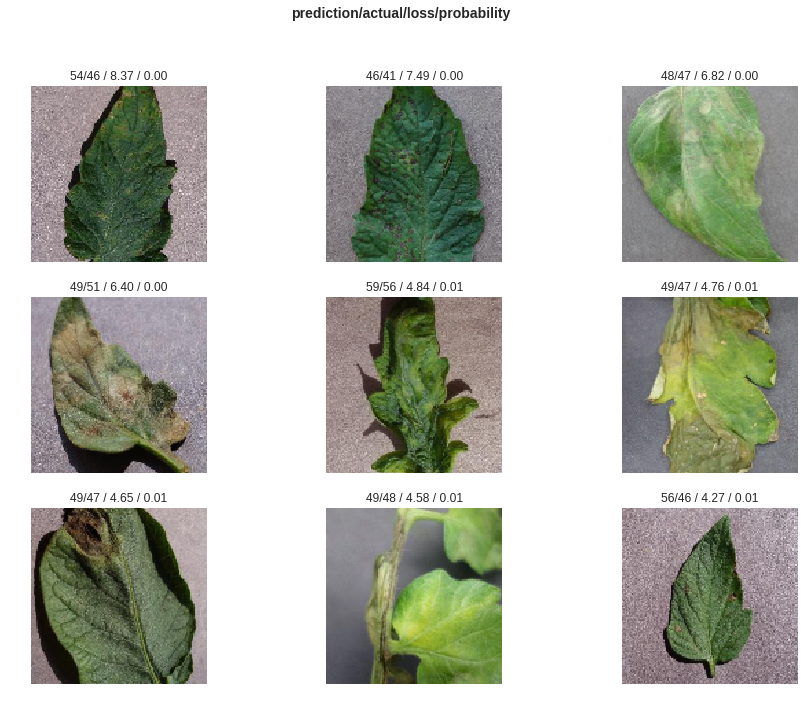

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

The confusion matrix looks pretty good.  There are a few classes that the model seems to have a hard time with. After investigating, it seems that class 58 is YLCV Virus general and class 59 is YLCV Virus serious.  It makes sense as to why the model is having difficulties with this scenario.  Both classes of leaves have the same disease, just of different levels of severity.

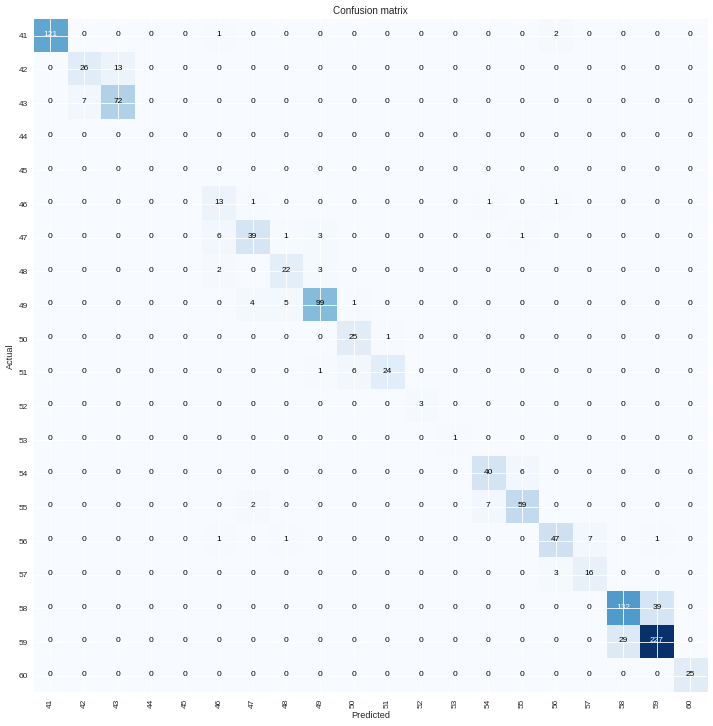

In [37]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

With this many classes, the confusion matrix can be become hard to read.  The following prints out the classes that we confused with one another most often.

In [25]:
interp.most_confused(min_val=2)

[(58, 59, 39),
 (59, 58, 29),
 (42, 43, 13),
 (43, 42, 7),
 (55, 54, 7),
 (56, 57, 7),
 (47, 46, 6),
 (51, 50, 6),
 (54, 55, 6),
 (49, 48, 5),
 (49, 47, 4),
 (47, 49, 3),
 (48, 49, 3),
 (57, 56, 3)]

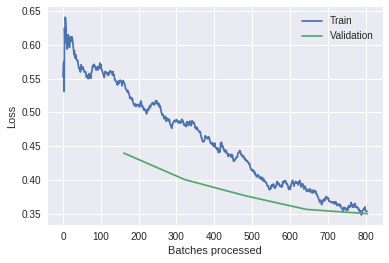

In [26]:
learn.recorder.plot_losses()

We now have a model that's pretty good at classifying images of size 128. let's increase the image sizes to 256 and train our model the new images and see what happens.

In [27]:
data = (src.transform(get_transforms(flip_vert=True), size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

Our images are now size 256. Let's freeze the earlier layers and start the whole process over again.

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,error_rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


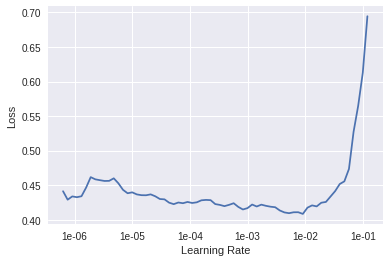

In [29]:
learn.lr_find()
learn.recorder.plot()

As expected the LR finder plot looks a little different with larger images.

In [0]:
lr=1e-2/2

In [31]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate
1,0.417170,0.441435,0.165650
2,0.457409,0.417344,0.163906
3,0.415122,0.373657,0.135135
4,0.365498,0.364875,0.136879
5,0.351556,0.367910,0.132520


We have a slight improvement.

In [0]:
# learn.save('stage-3-res34-tom')
learn.load('stage-3-res34-tom');

In [0]:
learn.unfreeze()

In [50]:
learn.fit_one_cycle(3, slice(1e-6, lr/5))

epoch,train_loss,valid_loss,error_rate
1,0.347179,0.377177,0.144725
2,0.341602,0.379416,0.141238
3,0.326585,0.365120,0.131648


Again, we can see a slight improvement.

In [0]:
learn.save('stage-4-res34-tom')

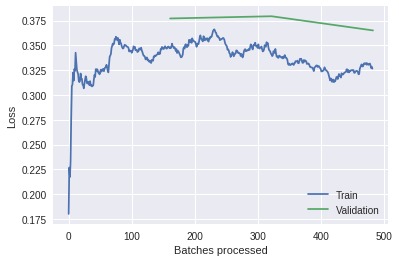

In [52]:
learn.recorder.plot_losses()

In [0]:
learn.export()